В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [32]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [33]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [146]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,
                 hidden_layer_sizes =(40,30,20),not_improve_iters =1000,tol =1e-10):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        
        self.hidden_layer_sizes =hidden_layer_sizes;
        self.layers_count =len(hidden_layer_sizes);
        
        self.not_improve_iters =not_improve_iters;
        self.tol =tol;
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_arr):
        layers =len(n_arr);
        W_arr =[];
        b_arr =[];
        W_first = np.random.randn(n_arr[0], n_x) * 0.01;
        b_first = np.zeros((n_arr[0], 1));
        W_arr.append(W_first);
        b_arr.append(b_first);
        for n_l in range(1,layers):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        W_last =np.random.randn(1, n_arr[layers-1]) * 0.01
        b_last = 0;      
        W_arr.append(W_last);
        b_arr.append(b_last); 
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    def __forward_propagation(self, X):
        
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]   
        W_first = W_arr[0];
        b_first = b_arr[0];     
        W_last =W_arr[len(W_arr)-1];
        b_last =b_arr[len(b_arr)-1];    
        Z_arr =[];
        A_arr =[];
        Z_first =np.dot(W_first,X)+b_first;
        A_first = self.__sigmoid(Z_first);  
        Z_arr.append(Z_first);
        A_arr.append(A_first); 
        layers = self.layers_count;
        for l in range(1,layers+1):
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);
        cache =(W_arr,b_arr,Z_arr,A_arr); 
        return A_arr[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W_arr,b_arr,Z_arr,A_arr) = cache  
        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];  
        dZ_last = A_arr[-1] -Y;
        dW_last = 1. / m * np.dot(dZ_last, A_arr[-2].T);
        db_last =1. / m * np.sum(dZ_last, axis = 1, keepdims = True);
        dA_last =np.dot(W_arr[-1].T,dZ_last);    
        dZ_arr.insert(0,dZ_last);
        dW_arr.insert(0,dW_last);
        db_arr.insert(0,db_last);
        dA_arr.insert(0,dA_last);
        for l_inv in range(len(W_arr)-2,0,-1):
            
            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv])); 
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);   
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        dA_first =dA_arr[0];
        dZ_first = np.multiply(dA_first, np.multiply(A_arr[0], 1 - A_arr[0]));
        dW_first = 1. / m * np.dot(dZ_first, X.T)
        db_first =1. / m * np.sum(dZ_first, axis = 1, keepdims = True)
        
        dZ_arr.insert(0,dZ_first); 
        dW_arr.insert(0,dW_first);
        db_arr.insert(0,db_first);
        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
    
    def __update_parameters(self, grads):
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];  
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];  
        W_new_arr =W_arr.copy();
        b_new_arr = b_arr.copy();
        for l in range(0,len(W_arr)):
            W_new_arr[l]-=self.learning_rate * dW_arr[l];
            b_new_arr[l]-=self.learning_rate * db_arr[l];  
        self.parameters["W_arr"] = W_new_arr;
        self.parameters["b_arr"] = b_new_arr;
       
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[];
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            
            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if i%self.not_improve_iters ==0:
                improve_costs.append(cost);
                imp_len =len(improve_costs);
                if imp_len >2:
                    if abs(improve_costs[imp_len-1] - improve_costs[imp_len-2]) < self.tol:
                        return;
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)  

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [147]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [148]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


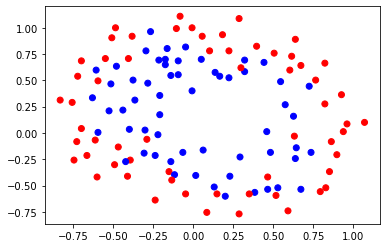

In [149]:
plot_data(X, Y)

In [150]:
cls = NeuralNet(normalize = True, learning_rate = 0.01, num_iter = 10001,hidden_layer_sizes = (2,),not_improve_iters=10000,tol=1e-8)

0-th iteration: 0.6931618895350937
1000-th iteration: 0.6929941112398984
2000-th iteration: 0.6929895553590509
3000-th iteration: 0.6929836208642541
4000-th iteration: 0.6929755796931943
5000-th iteration: 0.6929645819109175
6000-th iteration: 0.6929494910109737
7000-th iteration: 0.6929287947431397
8000-th iteration: 0.6929005081583386
9000-th iteration: 0.6928620844790848
10000-th iteration: 0.6928103657780209


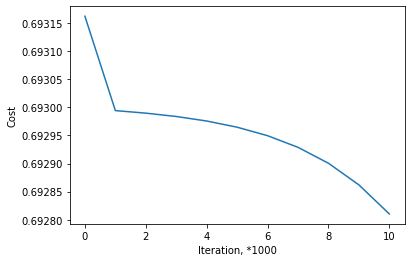

In [151]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [152]:
print(cls.parameters)

{'W_arr': [array([[ 0.10883712, -0.00929346],
       [ 0.01811403,  0.00628114]]), array([[-0.09604516, -0.00813138]])], 'b_arr': [array([[-1.56959260e-03],
       [-6.87641884e-05]]), array([[0.01521669]])]}


In [153]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.4895423 , 0.5104577 ],
       [0.49014796, 0.50985204],
       [0.49298302, 0.50701698],
       [0.49138157, 0.50861843],
       [0.49193006, 0.50806994],
       [0.49167307, 0.50832693],
       [0.49264417, 0.50735583],
       [0.48866636, 0.51133364],
       [0.48919491, 0.51080509],
       [0.49172124, 0.50827876],
       [0.49070297, 0.50929703],
       [0.49191352, 0.50808648],
       [0.48983889, 0.51016111],
       [0.49093093, 0.50906907],
       [0.49122723, 0.50877277],
       [0.48916436, 0.51083564],
       [0.49265769, 0.50734231],
       [0.48913751, 0.51086249],
       [0.49078041, 0.50921959],
       [0.48997677, 0.51002323],
       [0.49126452, 0.50873548],
       [0.49198583, 0.50801417],
       [0.49235858, 0.50764142],
       [0.49111823, 0.50888177],
       [0.49264709, 0.50735291],
       [0.49149993, 0.50850007],
       [0.49253484, 0.50746516],
       [0.49211117, 0.50788883],
       [0.49038736, 0.50961264],
       [0.49020227, 0.50979773],
       [0.

In [154]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [155]:
accuracy_score(Y, Y_hat)

0.5084745762711864

C:\Users\MacBook\AppData\Local\Temp/ipykernel_16660/1714921773.py:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


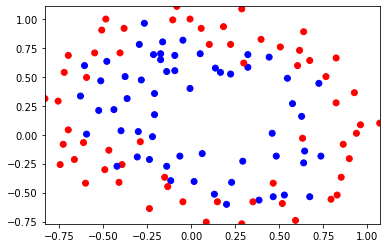

In [156]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [157]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (8,), max_iter = 1000000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [158]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(8,), learning_rate_init=0.01,
              max_iter=1000000, solver='sgd')

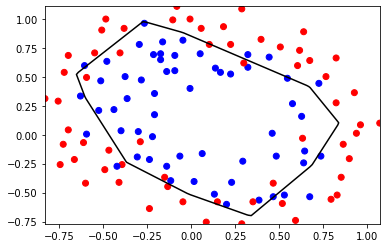

In [159]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [160]:
accuracy_score(Y, clf.predict(X))

0.8305084745762712

In [161]:
clf.n_iter_

1473